# PCA Coefficient Exploration for Multi-Marginal Data

This notebook explores PCA coefficients from multi-marginal random field data generated via coarse-graining.

**Objectives:**
- Load and inspect PCA coefficient data
- Visualize coefficient evolution across marginals
- Analyze variance explained and dimensionality reduction
- Reconstruct and compare fields from coefficients

## 1. Setup and Imports

In [1]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from pathlib import Path
from typing import Dict, List

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Setup complete!")

Setup complete!


## 2. Load PCA Coefficient Data

In [2]:
# Specify the path to your PCA coefficient data
data_path = '../data/mm_data_large.npz'

# Load the npz file
data = np.load(data_path)

# Extract marginal keys and sort by time
marginal_keys = sorted(
    [k for k in data.keys() if k.startswith('marginal_')],
    key=lambda x: float(x.split('_')[1])
)

# Extract time values
time_values = np.array([float(k.split('_')[1]) for k in marginal_keys])

# Load marginal coefficients
marginal_coeffs = [data[k] for k in marginal_keys]

# Load PCA metadata
pca_components = data['pca_components']
pca_mean = data['pca_mean']
pca_explained_variance = data['pca_explained_variance']
data_dim = int(data['data_dim'])
is_whitened = bool(data.get('is_whitened', True))

print(f"Dataset Overview:")
print(f"  Number of marginals: {len(marginal_keys)}")
print(f"  Time values: {time_values}")
print(f"  Number of samples per marginal: {marginal_coeffs[0].shape[0]}")
print(f"  Number of PCA coefficients: {marginal_coeffs[0].shape[1]}")
print(f"  Original data dimension: {data_dim}")
print(f"  Coefficients whitened: {is_whitened}")
print(f"  Resolution: {int(np.sqrt(data_dim))}x{int(np.sqrt(data_dim))}")

Dataset Overview:
  Number of marginals: 5
  Time values: [0.   0.25 0.5  0.75 1.  ]
  Number of samples per marginal: 5000
  Number of PCA coefficients: 378
  Original data dimension: 1024
  Coefficients whitened: False
  Resolution: 32x32


## 3. Analyze PCA Variance Explained

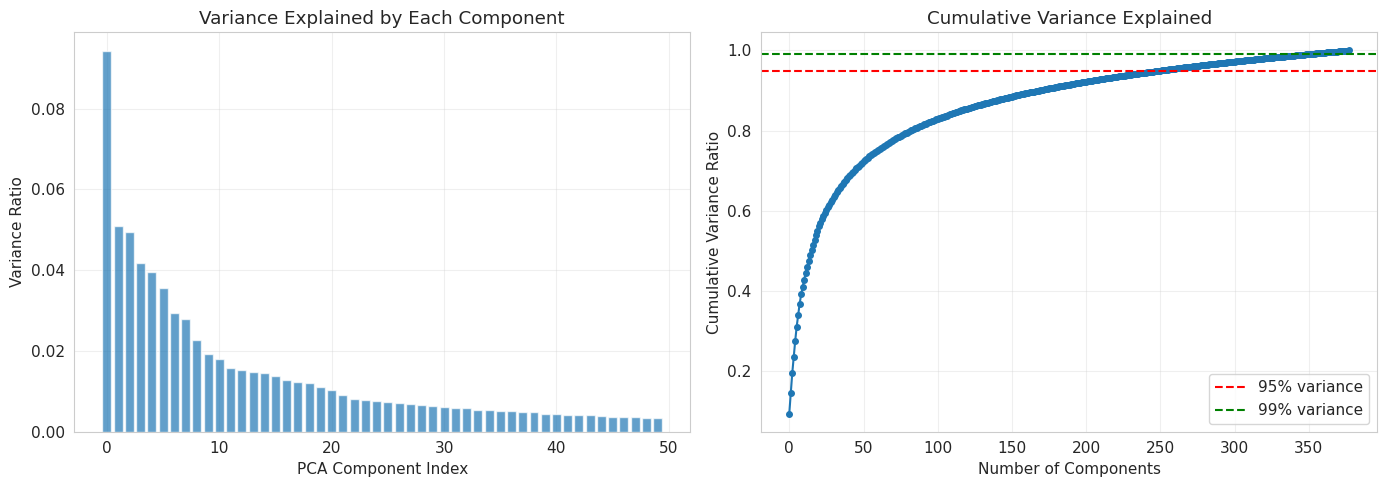


Components needed for 95% variance: 251
Components needed for 99% variance: 349
Total variance captured: 1.0000


In [3]:
# Calculate cumulative variance explained
total_variance = np.sum(pca_explained_variance)
variance_ratio = pca_explained_variance / total_variance
cumulative_variance = np.cumsum(variance_ratio)

# Plot variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance per component
n_components_to_show = min(50, len(variance_ratio))
axes[0].bar(range(n_components_to_show), variance_ratio[:n_components_to_show], alpha=0.7)
axes[0].set_xlabel('PCA Component Index')
axes[0].set_ylabel('Variance Ratio')
axes[0].set_title('Variance Explained by Each Component')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(len(cumulative_variance)), cumulative_variance, 'o-', markersize=4)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[1].axhline(y=0.99, color='g', linestyle='--', label='99% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Ratio')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for thresholds
n_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_99 = np.argmax(cumulative_variance >= 0.99) + 1
print(f"\nComponents needed for 95% variance: {n_95}")
print(f"Components needed for 99% variance: {n_99}")
print(f"Total variance captured: {cumulative_variance[-1]:.4f}")

## 4. Visualize Coefficient Evolution Across Marginals

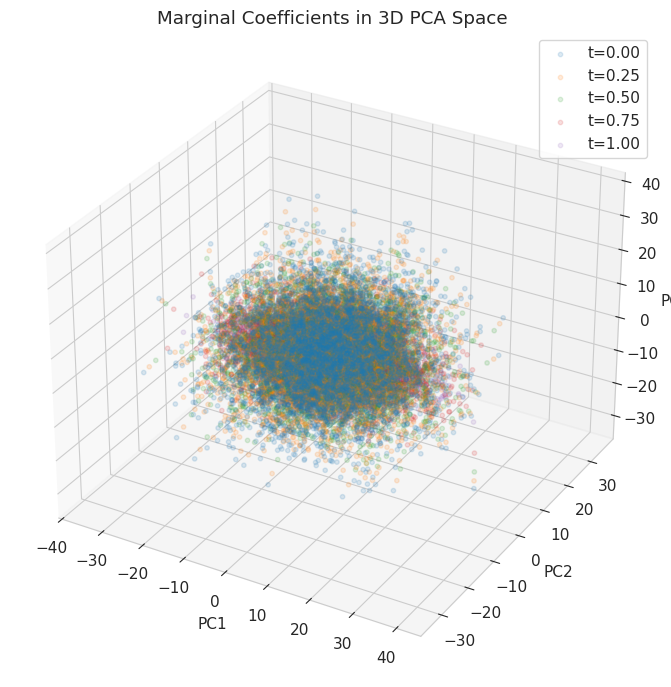

In [5]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(projection='3d')

colors = sns.color_palette('tab10', len(time_values))
for coeffs, t, color in zip(marginal_coeffs, time_values, colors):
    ax.scatter(coeffs[:, 0], coeffs[:, 1], coeffs[:, 2],
               s=10, alpha=0.15, color=color, label=f't={t:.2f}')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Marginal Coefficients in 3D PCA Space')
ax.legend()
plt.tight_layout()
plt.show()

Time 0.00
Time 0.25
Time 0.50
Time 0.75
Time 1.00


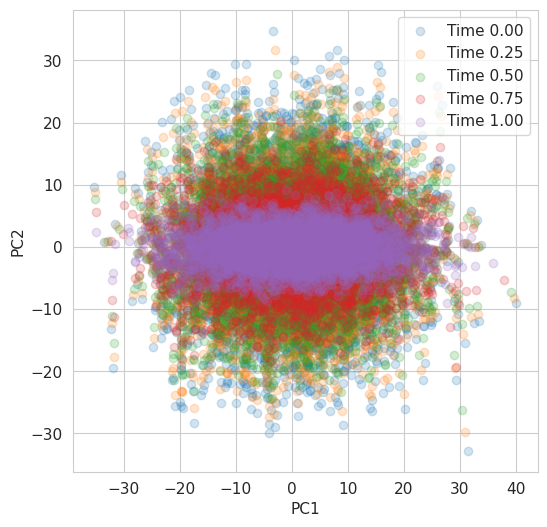

In [102]:
# whiten the coefficients and plot
# plot PC1 vs PC2 scatter at every time point
fig, ax = plt.subplots(figsize=(6, 6))
for i, t in enumerate(time_values):
    coeffs = marginal_coeffs[i]
    coeffs_whitened = coeffs * 1/(np.sqrt(pca_explained_variance))
    # label all time points
    print(f'Time {t:.2f}')
    ax.scatter(coeffs[:, 0], coeffs[:, 1], alpha=0.2, label=f'Time {t:.2f}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

## 5. Coefficient Statistics Across Time

## 6. Sample Trajectory Visualization

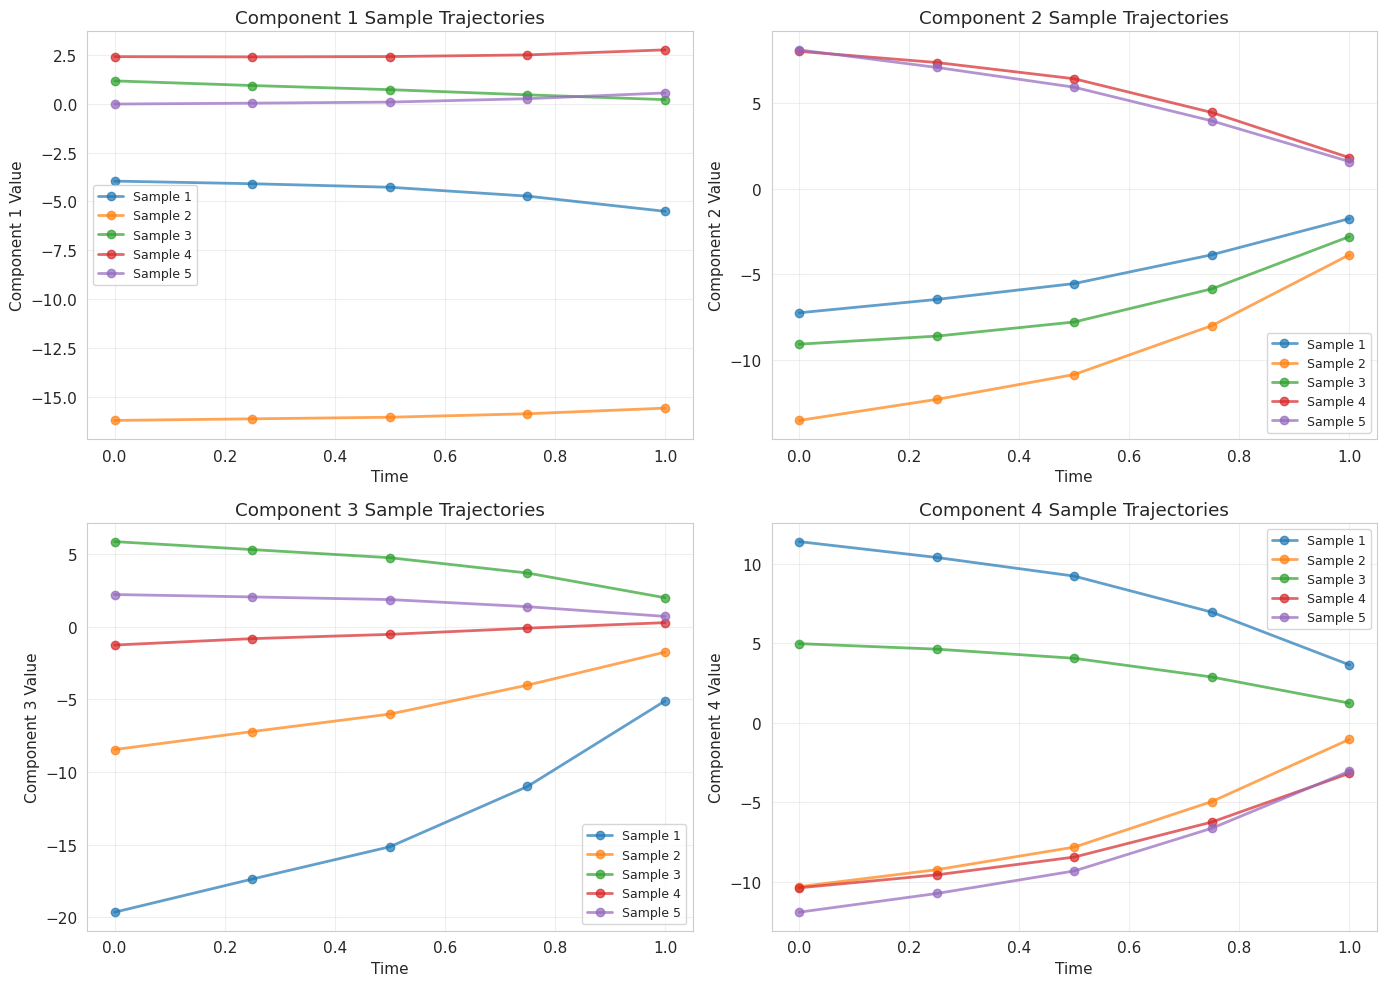

In [104]:
# Visualize individual sample trajectories through coefficient space
n_samples_to_plot = 5
n_components_to_plot = min(4, marginal_coeffs[0].shape[1])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Extract trajectories for specific samples
for comp_idx in range(n_components_to_plot):
    ax = axes[comp_idx]
    
    for sample_idx in range(n_samples_to_plot):
        trajectory = np.array([m[sample_idx, comp_idx] for m in marginal_coeffs])
        ax.plot(time_values, trajectory, 'o-', label=f'Sample {sample_idx+1}', 
                markersize=6, alpha=0.7, linewidth=2)
    
    ax.set_xlabel('Time')
    ax.set_ylabel(f'Component {comp_idx+1} Value')
    ax.set_title(f'Component {comp_idx+1} Sample Trajectories')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Reconstruct Random Fields from Coefficients

In [105]:
def reconstruct_fields_from_coefficients(coeffs: np.ndarray) -> np.ndarray:
    """Reconstruct original fields from PCA coefficients.
    
    Args:
        coeffs: Array of shape (n_samples, n_components)
    
    Returns:
        fields: Array of shape (n_samples, resolution, resolution)
    """
    resolution = int(np.sqrt(data_dim))
    
    if is_whitened:
        # For whitened coefficients: x = φ * sqrt(λ) * η + mean
        sqrt_eig = np.diag(np.sqrt(np.maximum(pca_explained_variance, 1e-12)))
        eigenvectors = pca_components.T
        scaled_coeffs = coeffs @ sqrt_eig
        reconstructed = scaled_coeffs @ eigenvectors.T + pca_mean
        
        # scale with the scaler in ['data_scale']
        if 'data_scale' in data:
            data_scale = data['minmax_data_scale']
            data_min = data['minmax_data_min']
            reconstructed = reconstructed * data_scale + data_min
        
    else:
        # For standard coefficients: x = φ^T * η + mean
        reconstructed = coeffs @ pca_components + pca_mean
        if 'data_scale' in data:
            data_scale = data['data_scale']
            reconstructed *= data_scale
    
    # Reshape to 2D fields
    fields = reconstructed.reshape(-1, resolution, resolution)
    return fields

# Reconstruct all marginals
reconstructed_marginals = [reconstruct_fields_from_coefficients(m) for m in marginal_coeffs]

print(f"Reconstructed fields shape per marginal: {reconstructed_marginals[0].shape}")

Reconstructed fields shape per marginal: (5000, 32, 32)


## 8. Visualize Reconstructed Fields

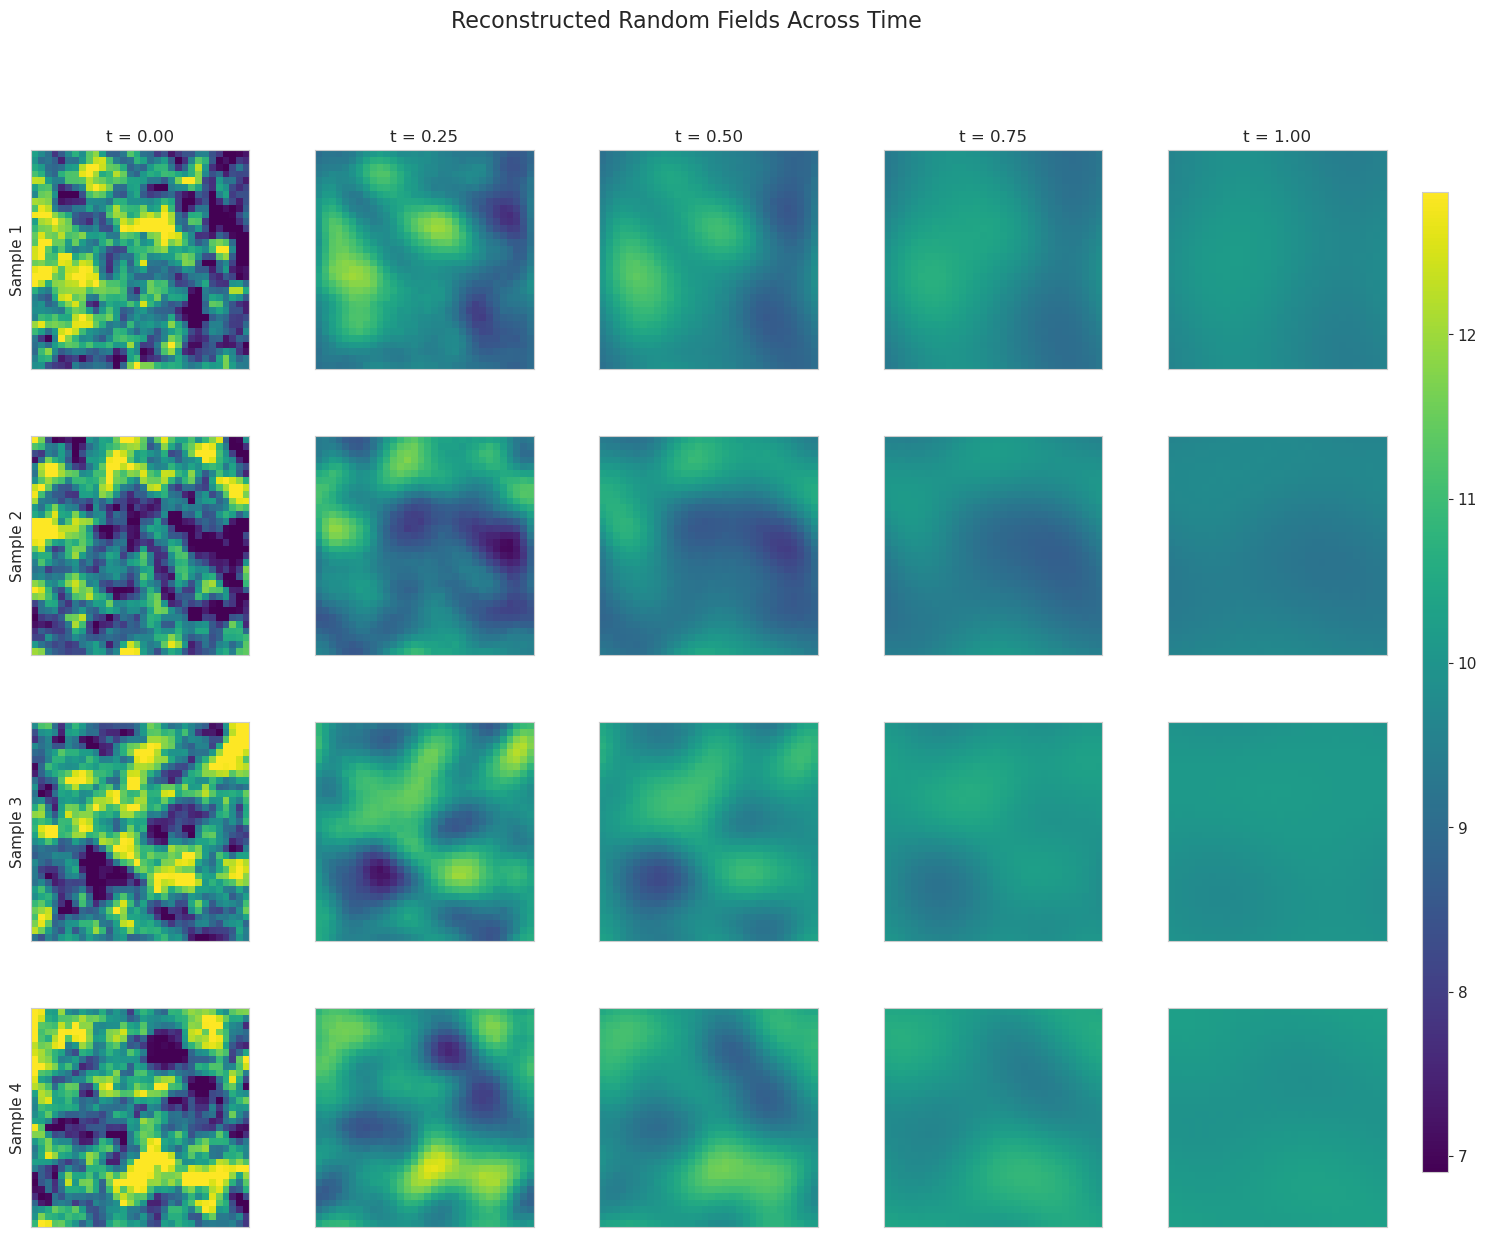

In [106]:
# Plot reconstructed fields at different time points for multiple samples
n_samples_to_show = 4
n_marginals = len(time_values)

fig = plt.figure(figsize=(3.5 * n_marginals, 3.5 * n_samples_to_show))
gs = gridspec.GridSpec(n_samples_to_show, n_marginals, figure=fig, hspace=0.3, wspace=0.3)

# Find global vmin/vmax for consistent coloring
all_fields = np.concatenate([f[:n_samples_to_show] for f in reconstructed_marginals])
vmin, vmax = np.percentile(all_fields, [1, 99])

for sample_idx in range(n_samples_to_show):
    for marginal_idx in range(n_marginals):
        ax = fig.add_subplot(gs[sample_idx, marginal_idx])
        field = reconstructed_marginals[marginal_idx][sample_idx]
        
        im = ax.imshow(field, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if sample_idx == 0:
            ax.set_title(f't = {time_values[marginal_idx]:.2f}', fontsize=12)
        if marginal_idx == 0:
            ax.set_ylabel(f'Sample {sample_idx+1}', fontsize=11)

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle('Reconstructed Random Fields Across Time', fontsize=16, y=0.98)
plt.show()